In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from ast import literal_eval

plt.rcParams['figure.figsize'] = [8, 6]
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

%matplotlib inline

# Loading The Dataset

In [6]:
movies = pd.read_csv('ml-latest/movies_metadata.csv.zip')
movies.id = movies.id.str.replace('-', '0').astype('int')
movies.drop(['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 
             'poster_path', 'status', 'tagline', 'title', 'video'], axis=1, inplace=True)

credits = pd.read_csv('ml-latest/credits.csv.zip')
credits.drop(['cast'], axis=1, inplace=True)

C:\Users\Amit2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning & Feature Engineering

In [7]:
def extract_director_name(x):
    
    directors = []
    for entry in x:
        job = entry.get('job')
        if job == 'Director':
            directors.append(entry.get('name'))

    return np.nan if directors == [] else " ".join(directors)

In [8]:
def extract_name_key(row):
    
    names = []
    for entry in row:
        name = entry['name']
        names.append(name)
    
    if names == []:
        return np.nan
    else:
        return " ".join(names)
#     return [x['name'] for x in row] if isinstance(row, list) else 'Unknown'

In [13]:
def weighted_rating(x, m=m, C=C):
    
    v = x['vote_count']
    R = x['vote_average']
    
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [11]:
movies_credits = pd.merge(movies, credits, on='id')

**Creating `Score` Feature**<br>
Same as Loren did

In [14]:
m = movies_credits.vote_count.quantile(.90)
C = movies_credits.vote_average.mean()
movies_credits['score'] = movies_credits.apply(weighted_rating, axis=1)

**Extracting The Directors Names**

In [15]:
directors = movies_credits.crew.apply(literal_eval).map(lambda x: extract_director_name(x))
movies_credits['directors'] = directors
movies_credits.directors = movies_credits.directors.replace(np.nan, 'unknown')
movies_credits.drop(['crew'], axis=1, inplace=True)

**Converting Data Types**

In [ ]:
movies_credits.budget = movies_credits.budget.astype('float')
movies_credits.popularity = movies_credits.popularity.astype('float')

**Dealing With The Date Feature**

In [16]:
movies_credits.release_date = pd.to_datetime(movies_credits.release_date)
movies_credits['release_year'] = movies_credits.release_date.dt.year
movies_credits['release_month'] = movies_credits.release_date.dt.month
movies_credits.drop(['release_date'], axis=1, inplace=True)

**Extract Genres, Production Companies and Countries, Spoken Languages**<br>
As this information was given as a dictionary, I had to pre-process it a bit

In [17]:
movies_credits['genres'] = movies_credits.genres\
                                .fillna('[]')\
                                .apply(literal_eval)\
                                .apply(extract_name_key)
            
movies_credits.genres = movies_credits.genres.replace(np.nan, 'unknown')
            
            
movies_credits['production_companies'] = movies_credits.production_companies\
                                                            .fillna('[]')\
                                                            .apply(literal_eval)\
                                                            .apply(extract_name_key)
            
movies_credits.production_companies = movies_credits.production_companies.replace(np.nan, 'unknown')


movies_credits['production_countries'] = movies_credits.production_countries\
                                                            .fillna('[]')\
                                                            .apply(literal_eval)\
                                                            .apply(extract_name_key)
            
movies_credits.production_countries = movies_credits.production_countries.replace(np.nan, 'unknown')
            
movies_credits['spoken_languages'] = movies_credits.spoken_languages\
                                                    .fillna('[]')\
                                                    .apply(literal_eval)\
                                                    .apply(extract_name_key)
            
movies_credits.spoken_languages = movies_credits.spoken_languages.replace(np.nan, 'unknown')

movies_credits.original_language = movies_credits.original_language.replace(np.nan, 'unknown')

movies_credits.overview = movies_credits.overview.replace(np.nan, 'No overview found.')

# Exploratory Data Analysis

## Some Statistics

In [18]:
movies_credits.head(3)

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,score,directors,release_year,release_month
0,30000000.0,Animation Comedy Family,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,373554033.0,81.0,English,7.7,5415.0,7.640254,John Lasseter,1995.0,10.0
1,65000000.0,Adventure Fantasy Family,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures Teitler Film Interscope Commu...,United States of America,262797249.0,104.0,English Français,6.9,2413.0,6.820294,Joe Johnston,1995.0,12.0
2,0.0,Romance Comedy,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,Warner Bros. Lancaster Gate,United States of America,0.0,101.0,English,6.5,92.0,5.940147,Howard Deutch,1995.0,12.0


In [20]:
movies_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45538 entries, 0 to 45537
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                45538 non-null  float64
 1   genres                45538 non-null  object 
 2   id                    45538 non-null  int32  
 3   original_language     45538 non-null  object 
 4   original_title        45538 non-null  object 
 5   overview              45538 non-null  object 
 6   popularity            45535 non-null  float64
 7   production_companies  45538 non-null  object 
 8   production_countries  45538 non-null  object 
 9   revenue               45535 non-null  float64
 10  runtime               45278 non-null  float64
 11  spoken_languages      45538 non-null  object 
 12  vote_average          45535 non-null  float64
 13  vote_count            45535 non-null  float64
 14  score                 45535 non-null  float64
 15  directors          

In [77]:
movies_credits.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,score,release_year,release_month
count,4.553800e+04,45538.000000,45535.000000,4.553500e+04,45278.000000,45535.000000,45535.000000,45535.000000,45451.000000,45451.000000
mean,4.223284e+06,108316.948527,2.921916,1.119860e+07,94.128517,5.618232,109.791128,5.724829,1991.882027,6.458736
std,1.741372e+07,112403.610181,6.002211,6.428227e+07,38.396184,1.924203,490.920864,0.311758,24.057726,3.628464
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.584909,1874.000000,1.000000
25%,0.000000e+00,26411.500000,0.386277,0.000000e+00,85.000000,5.000000,3.000000,5.610400,1978.000000,3.000000
50%,0.000000e+00,60012.500000,1.128317,0.000000e+00,95.000000,6.000000,10.000000,5.634861,2001.000000,7.000000
75%,0.000000e+00,157170.750000,3.681459,0.000000e+00,107.000000,6.800000,34.000000,5.718445,2010.000000,10.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,8.445870,2020.000000,12.000000


In [22]:
movies_credits.isnull().sum().sort_values(ascending=False)

runtime                 260
release_month            87
release_year             87
score                     3
vote_count                3
vote_average              3
revenue                   3
popularity                3
original_title            0
genres                    0
id                        0
original_language         0
production_countries      0
overview                  0
production_companies      0
spoken_languages          0
directors                 0
budget                    0
dtype: int64

## Features Distribution

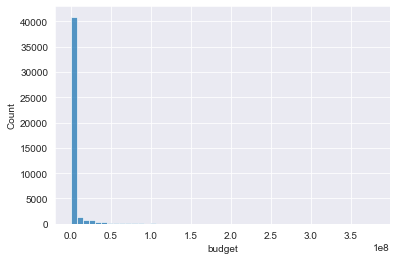

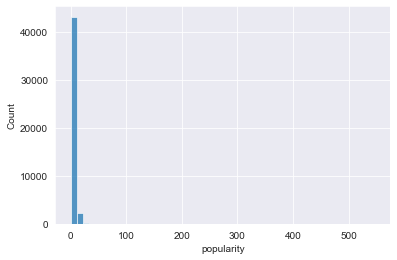

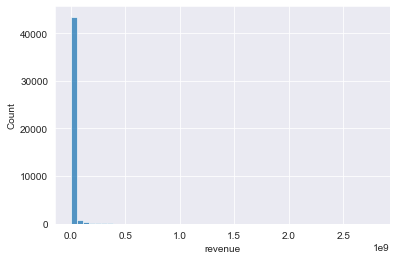

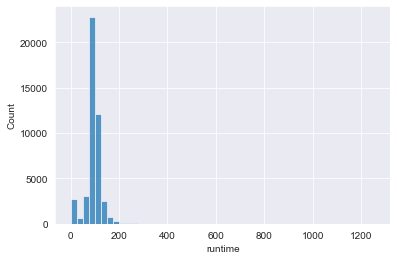

In [23]:
num_cont = ['budget', 'popularity', 'revenue', 'runtime']
for feat in num_cont:
    sns.histplot(data=movies_credits[feat], bins=50)
    plt.show()

In terms of `budget`, `popularity`, `revenue`, the movies are not too different from each other.<br>
We'll further examine that later on.. 

**Most Used Languages**

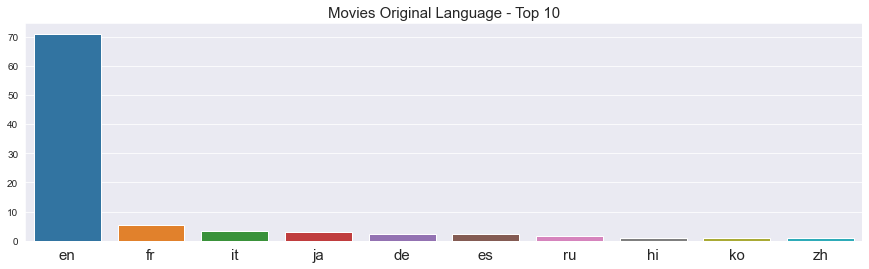

In [24]:
to_bar = movies_credits.original_language.value_counts(normalize=True)*100
plt.figure(figsize=(15, 4))
plt.title('Movies Original Language - Top 10', fontsize=15)
sns.barplot(y=to_bar.head(10).values, x=to_bar.head(10).index)
plt.xticks(fontsize=15)
plt.show()

The vast majority of the movies (around 70%) were filmed in `English`.<br>
`Francias`, `italiano` and few other languages also being represented in the dataset.<br>
All the other languages are barely used by the movies in the dataset

**Most Voted Movies**

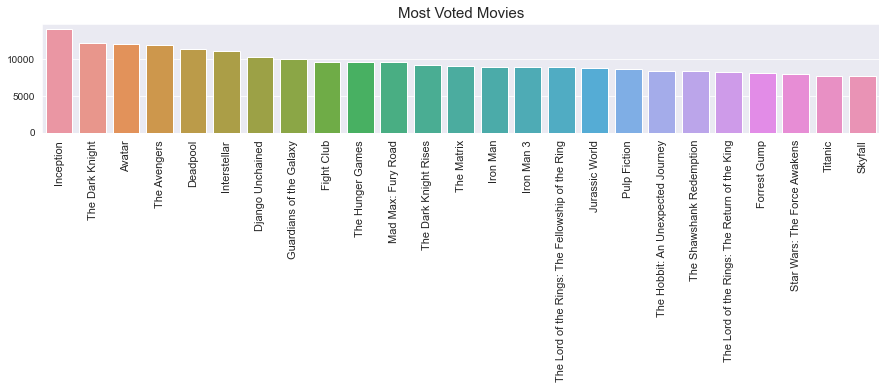

In [25]:
most_voted = movies_credits[['original_title', 'vote_count']].sort_values(by='vote_count', 
                                                                          ascending=False).head(25)

plt.figure(figsize=(15, 2))
sns.barplot(y=most_voted['vote_count'], x=most_voted['original_title'])
plt.title("Most Voted Movies", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=90, fontsize=11)
plt.show()

**Most Popular Movies**

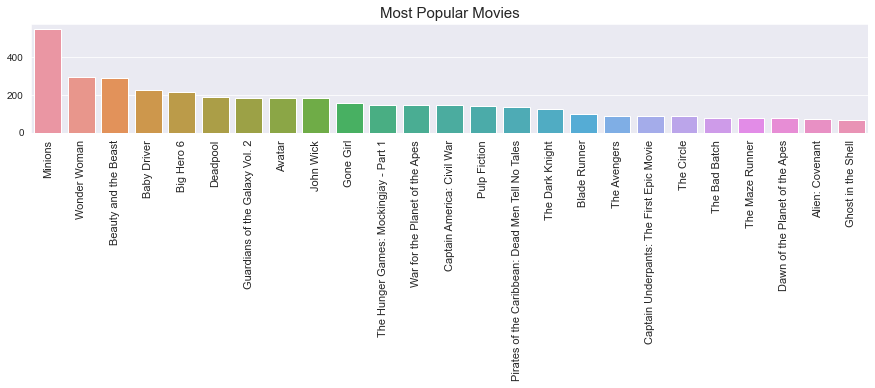

In [26]:
most_popular = movies_credits[['original_title', 'popularity']].sort_values(by='popularity', 
                                                                          ascending=False).head(25)

plt.figure(figsize=(15, 2))
sns.barplot(y=most_popular['popularity'], x=most_popular['original_title'])
plt.title("Most Popular Movies", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=90, fontsize=11)
plt.show()

**Movies With The Highest Score**

In [36]:
most_rated = movies_credits[['original_title', 'score']].sort_values(by='score', ascending=False)
    
most_rated.head(30)

,original_title,score
314,The Shawshank Redemption,8.445870
837,The Godfather,8.425439
10345,Dilwale Dulhania Le Jayenge,8.421458
12525,The Dark Knight,8.265477
2854,Fight Club,8.256385
292,Pulp Fiction,8.251406
522,Schindler's List,8.206640
23742,Whiplash,8.205405
5501,千と千尋の神隠し,8.196056
2219,La vita è bella,8.187173


**Movies Per Year**

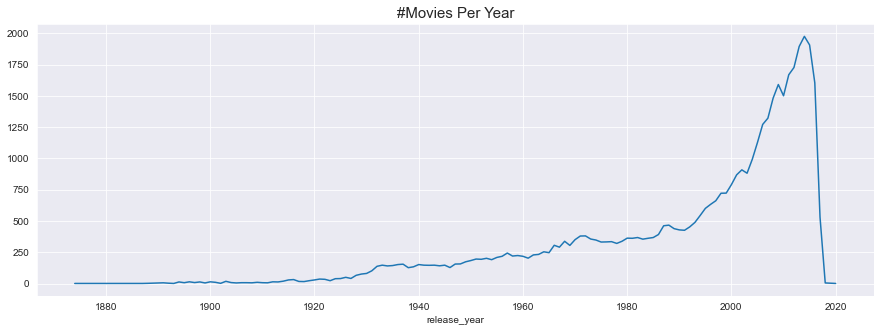

In [45]:
plt.figure(figsize=(15, 5))
plt.title("#Movies Per Year", fontsize=15)
movies_credits.groupby('release_year')['original_title'].count().plot()
plt.show()

**Movie Length vs Release Year**

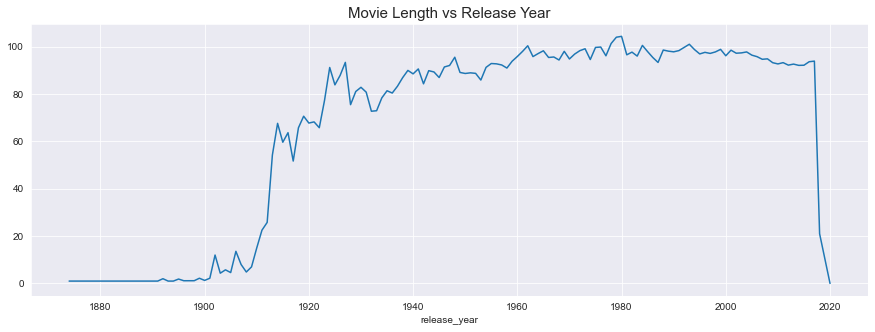

In [47]:
plt.figure(figsize=(15, 5))
plt.title("Movie Length vs Release Year", fontsize=15)
movies_credits.groupby('release_year')['runtime'].mean().plot()
plt.show()

**Movie Popularity vs Release Month**

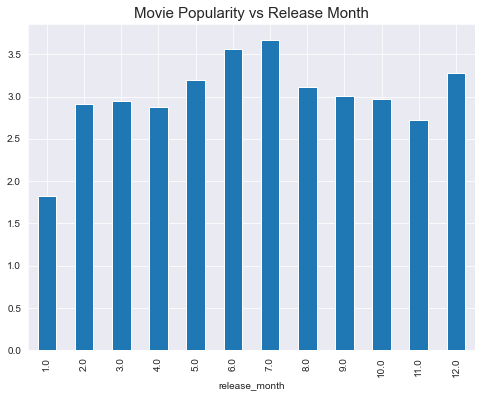

In [53]:
plt.figure(figsize=(8, 6))
movies_credits.groupby('release_month')['popularity'].mean().plot(kind='bar')
plt.title('Movie Popularity vs Release Month', fontsize=15)
plt.show()

In [54]:
movies_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45538 entries, 0 to 45537
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                45538 non-null  float64
 1   genres                45538 non-null  object 
 2   id                    45538 non-null  int32  
 3   original_language     45538 non-null  object 
 4   original_title        45538 non-null  object 
 5   overview              45538 non-null  object 
 6   popularity            45535 non-null  float64
 7   production_companies  45538 non-null  object 
 8   production_countries  45538 non-null  object 
 9   revenue               45535 non-null  float64
 10  runtime               45278 non-null  float64
 11  spoken_languages      45538 non-null  object 
 12  vote_average          45535 non-null  float64
 13  vote_count            45535 non-null  float64
 14  score                 45535 non-null  float64
 15  directors          

**Budget Vs Score**

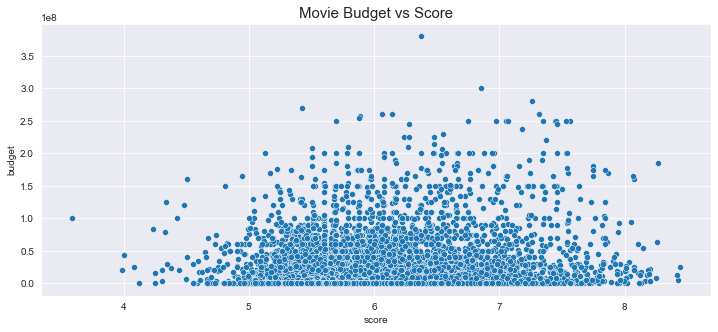

In [76]:
plt.figure(figsize=(12, 5))
sns.scatterplot(y=movies_credits['budget'], x=movies_credits['score'])
plt.title("Movie Budget vs Score", fontsize=15)
plt.show()

Surprisingly, I'd say, it seems like high budget is not guarantee for getting an high rating score at all!

**Budget vs Revenue**

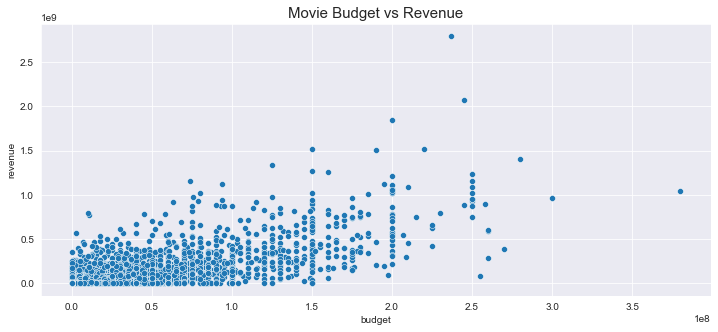

In [74]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=movies_credits['budget'], y=movies_credits['revenue'],
                x_jitter=True, y_jitter=True)
plt.title("Movie Budget vs Revenue", fontsize=15)
plt.show()